<a href="https://colab.research.google.com/github/bermanlabemory/motionmapperpy/blob/master/demo/motionmapper_fly_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The github repositories for motionmapper are - 

1. [MATLAB] **motionmapper** : https://github.com/gordonberman/MotionMapper

2. [PYTHON] **motionmapperpy** : https://github.com/bermanlabemory/motionmapperpy/


# 1.&nbsp; Downloading and installing motionmapperpy

First, we'll need to get motionmapperpy (sometimes we'll call it **mmpy** for brevity) from GitHub [image.png](https://github.com/bermanlabemory/motionmapperpy). 

Below we clone this github repository, which will download a copy of the repository on this COLAB runtime. 

In [6]:
# !git clone https://github.com/bermanlabemory/motionmapperpy

You'll notice the a **folder** named *motionmapperpy* created in the working directory in the left pane. This is the repository we just cloned and it contains the mmpy package and some toy datasets in the data folder. Note that our current working path is **/content/** in case you ever get lost. We still need to install motionmapperpy as a python package and we can do that by running this command - 



```
# Change to the motionmapperpy directory we just cloned into this colab instance
%cd motionmapperpy

# Install motionmapperpy as a python package to the current python environment
!python setup.py install

# Come out of the mmpy directory. 
%cd ..
```

\
\
\
*Quick note* : Colab instances come with many Python packages pre installed. You can run ```%pip list``` to see what packages are already present. 

In [7]:
# ## Install mmpy in this cell

# # Change to the motionmapperpy directory we just cloned into this colab instance
# %cd motionmapperpy

# # Install motionmapperpy as a python package to the current python environment
# !python setup.py install

# # Come out of the mmpy directory.
# %cd ..

# !pip3 install imageio==2.4.1

# # !pip install --upgrade imageio-ffmpeg

\
\
\
Great! We should have `motionmapperpy` installed on this colab runtime now! We'll **need to restart the runtime** so that this notebook is able to recognize motionmapperpy (meaning we can do ```import motionmapperpy```)
and its dependencies as python packages. We can restart the instance by going to **Runtime->Restart Runtime** in the **top menu bar**. It is equivalent to restarting the ipython kernel when working with Jupyter notebooks. 

Note that restarting the runtime does not delete files and folders we have created in this colab instance, or remove any python packages we've installed here. But doing **Factory Reset Runtime** will do all of those things so be careful! Also, note that Google will clear our colab instance if we're not using the instance for some arbitrarily brief amount, in which case the runtime will be factory reset and we'll lose .


Once you have restarted the runtime, you are good to move on to the next section!

# 2.&nbsp; Toy datasets 

There are three additional small datasets present within the motionmapper repository we cloned from GitHub. These are present in **`motionmapperpy/data`** path.

1. **Fly video dataset** : **fly_movie.avi** is video of a fly and **fly_movie_projections.mat** contains PCA projections obtained after segmentation and alignment of this frames/images from the movie. . 

2. **Mouse dataset** : **mouse_movie.avi** contains video of a mouse moving inside an arena. **mouse_movie_projections.mat** contains PCA projections obtained after segmentation and alignment of images/frames obtained from this movie.  

3. **Leap tracked fly dataset** : This dataset has two movies **fly_leap_test.mp4** and **fly_leap_test_2.mp4** with 2 corresponding h5 files containing 32 points tracked using [LEAP](https://dataspace.princeton.edu/handle/88435/dsp01pz50gz79z).

Try downloading the movies to check out what they look like. 





--------------------


Alright, lets get started! We'll focus on the LEAP tracked fly dataset as our toy example in this notebook. We'll import some packages to kick things off below. 

In [1]:
# Python standard library packages to do file/folder manipulations,
# pickle is a package to store python variables
import glob, os, pickle, sys

# time grabs current clock time and copy to safely make copies of large
# variables in memory.
import time, copy

# datetime package is used to get and manipulate date and time data
from datetime import datetime

# this packages helps load and save .mat files older than v7
import hdf5storage

# numpy works with arrays, pandas used to work with fancy numpy arrays
import numpy as np
import pandas as pd

# matplotlib is used to plot and animate to make movies
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# moviepy helps open the video files in Python
from moviepy.editor import VideoClip, VideoFileClip
from moviepy.video.io.bindings import mplfig_to_npimage

# Scikit-learn is a go-to library in Python for all things machine learning
from sklearn.decomposition import PCA

# tqdm helps create progress bars in for loops
from tqdm import tqdm

# Scipy is a go-to scientific computing library. We'll use it for median filtering.
from scipy.ndimage import median_filter

# Configuring matplotlib to show animations in a colab notebook as javascript
# objects for easier viewing.
from matplotlib import rc

rc("animation", html="jshtml")

Now we can load the files associated with this dataset. We'll read the two video files using `moviepy`, and the two .h5 tracking datasets using pandas. 

In [9]:
datasetnames = ["fly_leap_test", "fly_leap_test_2"]
print(os.getcwd())
clips = [VideoFileClip("../data/fly/%s.mp4" % d) for d in datasetnames]


h5s_pandas = [pd.read_hdf("../data/fly/%s_positions.h5" % d) for d in datasetnames]

/Genomics/ayroleslab2/scott/git/lts-manuscript/analysis/utils/motionmapperpy/demo


In [10]:
h5s_pandas[0]

scorer     LEAP                                                          \
bodyparts  head                    eyeL                     eyeR          
coords        x      y likelihood     x      y likelihood      x      y   
0          94.0  148.0   0.997976  78.0  135.0   0.936517  111.0  136.0   
1          95.0  147.0   0.966769  78.0  135.0   0.952672  111.0  135.0   
2          95.0  147.0   0.983893  78.0  135.0   0.944753  111.0  135.0   
3          95.0  147.0   0.975566  77.0  135.0   0.935152  111.0  135.0   
4          94.0  148.0   0.983482  77.0  135.0   0.934642  111.0  135.0   
...         ...    ...        ...   ...    ...        ...    ...    ...   
19995      96.0  147.0   0.977591  79.0  135.0   0.974096  113.0  134.0   
19996      96.0  147.0   0.901368  79.0  135.0   0.975037  113.0  135.0   
19997      97.0  148.0   0.965987  79.0  135.0   0.961830  113.0  134.0   
19998      97.0  148.0   0.946962  79.0  135.0   0.964133  115.0  133.0   
19999      97.0  148.0   0.942981  79.0  135.0   0.963280  115.0  133.0   

scorer                      ...                                              \
bodyparts             neck  ...  hindlegL3 hindlegL4                  wingL   
coords    likelihood     x  ... likelihood         x     y likelihood     x   
0           1.011603  95.0  ...   0.658106      81.0  45.0   0.378380  89.0   
1           0.985119  95.0  ...   0.583825      81.0  47.0   0.192607  89.0   
2           0.994426  95.0  ...   0.571004      81.0  47.0   0.285333  89.0   
3           0.991430  95.0  ...   0.519479      85.0  46.0   0.236658  89.0   
4           0.983904  95.0  ...   0.606728      81.0  46.0   0.399705  89.0   
...              ...   ...  ...        ...       ...   ...        ...   ...   
19995       0.900437  96.0  ...   0.921827      65.0  43.0   1.010905  93.0   
19996       0.939021  96.0  ...   0.931697      63.0  40.0   0.985959  92.0   
19997       0.958881  96.0  ...   0.888548      63.0  41.0   0.943244  91.0   
19998       0.913020  97.0  ...   0.943938      63.0  41.0   0.976252  92.0   
19999       0.964309  97.0  ...   0.915112      63.0  40.0   0.960774  93.0   

scorer                                              
bodyparts                   wingR                   
coords        y likelihood      x     y likelihood  
0          16.0   0.992454  102.0  17.0   0.914016  
1          16.0   0.990767  101.0  17.0   0.895895  
2          16.0   1.003834  101.0  17.0   0.971727  
3          16.0   0.973690  101.0  17.0   0.969307  
4          16.0   0.980679  101.0  17.0   0.983998  
...         ...        ...    ...   ...        ...  
19995      16.0   0.913688   99.0  15.0   0.990639  
19996      17.0   0.917335   99.0  15.0   0.960659  
19997      16.0   0.898105   99.0  15.0   1.003330  
19998      17.0   0.931574   99.0  15.0   0.980430  
19999      16.0   0.932209   99.0  15.0   0.962214  

[20000 rows x 96 columns]

Let's first explore some properties of the loaded movie clips and tracking data.

In [11]:
for i, m in enumerate(clips):
    print(
        "Clip %i is %i seconds long at %i fps. "
        "The frames are %i px wide and %i px high."
        % (i + 1, m.duration, m.fps, m.w, m.h)
    )
print()
for i, h5 in enumerate(h5s_pandas):
    print(".h5 file %i has shape %s." % (i, h5.shape))

print("\n\nLeap tracked 32 points on the fly. Why do you think we have 96 dimensions?")

Clip 1 is 200 seconds long at 100 fps. The frames are 192 px wide and 192 px high.
Clip 2 is 200 seconds long at 100 fps. The frames are 192 px wide and 192 px high.

.h5 file 0 has shape (20000, 96).
.h5 file 1 has shape (20000, 96).


Leap tracked 32 points on the fly. Why do you think we have 96 dimensions?


We can also use handy pandas functions ```.head()``` to look at the first few rows of the tracking dataset.

In [ ]:
h5s_pandas[0].head()

: 

It seems like the .h5 files have 32 bodyparts tracked, and there are 3 columns for each of the tracked bodyparts. They contain the `x` and `y` positions, as well as the *likelihood* value of the tracked position of each part. 

We'll ditch pandas now, and convert these datasets to numpy arrays since they're more intuitive to work with. Let's also remove all the likelihood columns in these numpy arrays (so every third column). 

In [12]:
# We're removing every 3rd column since that contains the likelihood values
inds_to_keep = np.mod(np.arange(1, h5.shape[1] + 1), 3) != 0
print(inds_to_keep)

h5s = [h5.values[:, inds_to_keep] for h5 in h5s_pandas]

[ True  True False  True  True False  True  True False  True  True False
  True  True False  True  True False  True  True False  True  True False
  True  True False  True  True False  True  True False  True  True False
  True  True False  True  True False  True  True False  True  True False
  True  True False  True  True False  True  True False  True  True False
  True  True False  True  True False  True  True False  True  True False
  True  True False  True  True False  True  True False  True  True False
  True  True False  True  True False  True  True False  True  True False]


Lets check what the arrays look like 

In [ ]:
print([h5.shape for h5 in h5s])

: 

To remove erratic tracking errors, we can median filter our data. We'll do that below and also reshape the data so that it is easier to work with.

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(h5s[0][:1000, :10])

: 

In [13]:
# Reshape the arrays so that they are easier to work with.
h5s = [median_filter(x, size=(5, 1)) for x in h5s]

h5s = [i.reshape((-1, i.shape[1] // 2, 2)) for i in h5s]
print("New shapes : %s" % ([i.shape for i in h5s]))

New shapes : [(20000, 32, 2), (20000, 32, 2)]


In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(h5s[0][:1000, 0])

: 

Great! Now we are ready to plot and see what our dataset looks like. Below we'll use `matplotlib` to overlay tracking data on the video files. We'll read video frames using moviepy `videofileclip` objects stored in `clips`. Running this cell may take upto **1 minute**.



In [14]:
# This will take about a 50 seconds to run.

fig, ax = plt.subplots(figsize=(10, 5))
h5ind = 0
tstart = 7000

connections = [
    np.arange(6, 10),
    np.arange(10, 14),
    np.arange(14, 18),
    np.arange(18, 22),
    np.arange(22, 26),
    np.arange(26, 30),
    [2, 0, 1],
    [0, 3, 4, 5],
    [31, 3, 30],
]

try:
    tqdm._instances.clear()
except:
    pass


def animate(t):
    t = int(t * clips[h5ind].fps) + tstart
    ax.clear()
    for conn in connections:
        ax.plot(h5s[h5ind][t, conn, 0], h5s[h5ind][t, conn, 1], "k-")
    for i in range(h5s[h5ind].shape[1]):
        ax.scatter(
            h5s[h5ind][t, i, 0],
            h5s[h5ind][t, i, 1],
            marker="$%i$" % i,
            s=200,
            color="k",
        )
    ax.imshow(
        clips[h5ind].get_frame((t) / clips[h5ind].fps), cmap="Greys", origin="lower"
    )
    ax.set_aspect("equal")
    ax.axis("off")

    return mplfig_to_npimage(fig)


anim = VideoClip(animate, duration=20)
plt.close()
anim.ipython_display(fps=20, loop=True, autoplay=True)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:   1%|▏         | 5/400 [00:01<01:33,  4.22it/s, now=None]

KeyboardInterrupt: 

## 2.1&nbsp; Data specific pre-processing

[![](http://www.accutrend.com/wp-content/uploads/2018/07/GiGo-570x315.jpg)](http://www.accutrend.com/it-still-comes-down-to-garbage-in-garbage-out/)

When working with any model, algorithm or pipeline, we have to be mindful of the data we are feeding into them. This section covers some (of many) tricks to process the input data before feeding into motionmapperpy. 

Working with the tracked bodypart positions can be challenging with flies, since there are a lot of correlations between the tracked points. We can visualize these in the plot below. 

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
_ = ax.plot(h5s[0][:1000, :].reshape((1000, -1)))
ax.set_xlabel("Frame #", fontsize=14)
ax.set_ylabel("X and Y positions (px)", fontsize=14)
# ax.set_ylim([-0.5,1.5])

: 

Instead, we can compute various angles using these 32 positions. Below, we'll compute 22 new angles in each frame using these positions, such as the angle between wingtips `(31, 0, 30)` in the image above. 

Working with angles is tricky since they will either fall between [-$\pi$, $\pi$] or [0, 2$\pi$], and we can have discontinuties at the boundaries. As a workaround, we can choose to compute the angles to vary over either of these two ranges. For example, the wingtips cross over very frequently so we'll choose to compute then over the [-$\pi$, $\pi$] interval. We'll indicate this choice by saying 0 (or 1 for the other choice) as the last list element in angleinds defined below.  

In [15]:
# convert to angles space

# [1,0,2,0] means the angle from 1 to 0 to 2 calculated over [-pi, pi] interval.
angleinds = [
    [1, 0, 2, 0],
    [0, 3, 4, 0],
    [3, 4, 5, 0],
    [31, 3, 30, 1],
    [6, 7, 8, 0],
    [7, 8, 9, 0],
    [10, 11, 12, 0],
    [11, 12, 13, 0],
    [14, 15, 16, 0],
    [15, 16, 17, 0],
    [26, 27, 28, 0],
    [27, 28, 29, 0],
    [22, 23, 24, 0],
    [23, 24, 25, 0],
    [18, 19, 20, 0],
    [19, 20, 21, 0],
    [3, 4, 18, 0],
    [3, 4, 22, 0],
    [3, 4, 26, 0],
    [3, 4, 6, 0],
    [3, 4, 10, 0],
    [3, 4, 14, 0],
]

# Empty array to hold computed angles.
angleh5s = [np.zeros((h5.shape[0], len(angleinds))) for h5 in h5s]

# Function to compute angle between two vectors.
def angle_between(v1, v2, small_angle=1):
    """
    Calculate angle between two vectors.

    Args:
    v1, v2 : Pair of vectors of shape (N, 2).
    small_angle : True if calculating over [-pi, pi],
                  False if calculating over [0, 2pi].

    Returns
    N angles in degrees.
    """
    ang1 = np.arctan2(v1[:, 1], v1[:, 0])
    ang2 = np.arctan2(v2[:, 1], v2[:, 0])
    if small_angle == 1:
        out = np.rad2deg((ang1 - ang2) % (2 * np.pi))
        out[out > 180] = -1 * (360 - out[out > 180])
        return out
    else:
        return np.rad2deg((ang1 - ang2) % (2 * np.pi))


for hi, h5 in enumerate(h5s):
    for ai, aind in enumerate(angleinds):
        v1 = h5[:, aind[0]] - h5[:, aind[1]]
        v2 = h5[:, aind[2]] - h5[:, aind[1]]
        angleh5s[hi][:, ai] = angle_between(v1, v2, small_angle=aind[3])

We can look at the angles time series below. We're plotting only 5 angles here just for the sake of visualization.

In [16]:
fig, ax = plt.subplots(figsize=(16, 8))
labels = [
    "Angle between wingtips",
    "Neck angle",
    "Right midleg femur-tibia angle",
    "Left foreleg coxa-femur angle",
    "Mesothorasic angle",
]
for i, l in zip([3, 1, 13, 4, 2], labels):
    _ = ax.plot(angleh5s[0][1000:2000, i] * np.pi / (180), label=l)
ax.set_xlabel("Frame #", fontsize=14)
ax.set_ylabel("Angles (Rad)", fontsize=14)
ax.legend()

It seems like some of these angles vary a lot and some very little. We can get rid of this asymmetry by doing a min-max scaling, where we constrain each angle to scale between 0 and 1. 

In [17]:
# let's normalize these angles so they fall bw 0 and 1

angleh5s_min = []
for ah5 in angleh5s:
    x = copy.deepcopy(ah5)
    x = x - np.min([np.min(x, 0) for x in angleh5s], 0)[None, :]
    angleh5s_min.append(x)

angleh5s_normed = []
for ah5min in angleh5s_min:
    x = copy.deepcopy(ah5min)
    x = x / np.max([np.max(x, 0) for x in angleh5s_min], 0)[None, :]
    angleh5s_normed.append(x)

fig, ax = plt.subplots(figsize=(16, 8))
labels = [
    "Angle between wingtips",
    "Neck angle",
    "Right midleg femur-tibia angle",
    "Left foreleg coxa-femur angle",
    "Mesothorasic angle",
]
for i, l in zip([3, 1, 13, 4, 2], labels):
    _ = ax.plot(angleh5s_normed[0][:1000, i], label=l)
ax.set_xlabel("Frame #", fontsize=14)
ax.set_ylabel("Normalized angles", fontsize=14)
ax.legend()
ax.set_ylim([0, 1.0])

(0.0, 1.0)

Now, we have a 22-dimensional feature space that is normalized, and we can use our favourite tool to reduce the dimensionality further to ease up on computational costs. Here, we'll use PCA to reduce the dimensions even further.

We're using the PCA implementation from [`sklearn.decomposition.PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) here.

In [18]:
angleh5s_normed[1].shape

(20000, 22)

In [19]:
# Concatenate the two files for downstream analyses
x = np.concatenate(angleh5s_normed, axis=0)
# x.shape -> 40000, 22
variance_threshold = 0.95

# We are using sklearn.decomposition.PCA here
p = PCA()
y = p.fit_transform(x)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    np.arange(1, x.shape[1] + 1),
    np.cumsum(p.explained_variance_ratio_),
    color="firebrick",
)

# This calculates the number of PCA components required to surpass teh variance threshold
comps_above_thresh = np.argwhere(
    np.cumsum(p.explained_variance_ratio_) > variance_threshold
)[0][0]

ax.axvline(x=comps_above_thresh, color="royalblue", linestyle="--", alpha=0.5)
ax.text(x=comps_above_thresh + 1, y=0.5, s="%ith component" % comps_above_thresh)
ax.set_xlabel("PCA Components")
ax.set_ylabel("Cumulative Explained Variance")
ax.grid()

print(
    "We'll pick the first %i components that"
    " explain %i%% variance." % (comps_above_thresh, variance_threshold * 100)
)

We'll pick the first 12 components that explain 95% variance.


We can look at the feature space composition of the leading principal components below. 

In [20]:
y.shape

(40000, 22)

In [21]:
fig, ax = plt.subplots(figsize=(20, 4))

for i in range(comps_above_thresh):
    for pi in range(x.shape[1]):
        ax.bar(
            (i - 0.4 + pi * (0.8 / x.shape[1])),
            p.components_[i, pi],
            width=(0.7 / x.shape[1]),
            label="Angle %i" % i,
        )
    ax.set_prop_cycle(None)

ax.set_xlabel("Leading PCA Components ")
ax.set_ylabel("Proportion along PC direction")
# ax.legend()
ax.grid()
plt.show()

This gives us some idea of how these maximally varying components are oriented in our high dimensional feature space.


Now we can reduce our feature space dimensions further! Note that here we use variable `y` which was obtained after the PCA transformation.

In [22]:
# picking PCA components above threshold
y = y[:, :comps_above_thresh]
print(y.shape)

# Let's also split y to the size of original h5 files.
projs_list = np.split(y, np.cumsum([h5.shape[0] for h5 in h5s])[:-1])

print([p.shape for p in projs_list])

(40000, 12)
[(20000, 12), (20000, 12)]


Now we have **projs_list**, which contains two (relatively) low-dimensional timeseries. 

# 3.&nbsp; Creating an mmpy project directory

Now that we have two low dimensional time series which **may** not set Google servers on fire, we will create our project directory for running the `motionmapperpy` pipeline on the data we have. Having a project directory is awesome, as it helps us stay organized when working with big datasets and multiple files. It allows datasets to be easily referenced and loaded without exhausting memory, and we can store pipeline outputs in well-defined and easy to read files.


Lets start by importing `motionmapperpy` and creating a project directory.

In [23]:
import motionmapperpy as mmpy


projectPath = "Fly_Leap_mmpy"

# This creates a project directory structure which will be used to store all motionmappery pipeline
# related data in one place.

mmpy.createProjectDirectory(projectPath)

Skipping, path already exists : Fly_Leap_mmpy
Skipping, path already exists : Fly_Leap_mmpy/Projections
Skipping, path already exists : Fly_Leap_mmpy/TSNE_Projections
Skipping, path already exists : Fly_Leap_mmpy/TSNE
Skipping, path already exists : Fly_Leap_mmpy/UMAP


Now lets store the two low-d time series in **projs_list** to the *`Projections`* folder in the project directory.



In [ ]:
for i, projs in enumerate(projs_list):
    hdf5storage.savemat(
        "%s/Projections/%s_pcaModes.mat" % (projectPath, datasetnames[i]),
        {"projections": projs},
    )

: 

We'll now go through `mmpy` parameters. They are a handful and can be overwhelming, but they are very easy to understand! 

Parameters are cruicial to `mmpy` as they lay out some hard-coded choices we need to make when running this pipeline. I will explain each parameter as we encounter them in the cell below, so please read through this cell below as you run it.


In [24]:
"""2. Setup run parameters for MotionMapper."""

#% Load the default parameters.
parameters = mmpy.setRunParameters()

In [25]:
parameters

{'numProcessors': 16,
 'numPeriods': 25,
 'omega0': 5,
 'samplingFreq': 100,
 'minF': 1,
 'maxF': 50,
 'tSNE_method': 'barnes_hut',
 'perplexity': 32,
 'embedding_batchSize': 128000,
 'maxOptimIter': 500,
 'trainingSetSize': 64000,
 'maxNeighbors': 200,
 'kdNeighbors': 5,
 'training_perplexity': 20,
 'training_numPoints': 32000,
 'minTemplateLength': 1,
 'waveletDecomp': True,
 'useGPU': -1,
 'n_neighbors': 15,
 'train_negative_sample_rate': 5,
 'embed_negative_sample_rate': 1,
 'min_dist': 0.1,
 'umap_output_dims': 2,
 'n_training_epochs': 100,
 'rescale_max': 100,
 'method': 'TSNE',
 'projectPath': 'mmpy_lts_1d'}

In [26]:
# %%%%%%% PARAMETERS TO CHANGE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# These need to be revised everytime you are working with a new dataset. #

parameters.projectPath = projectPath  #% Full path to the project directory.


parameters.method = "UMAP"  #% We can choose between 'TSNE' or 'UMAP'

parameters.minF = 1  #% Minimum frequency for Morlet Wavelet Transform

parameters.maxF = 50  #% Maximum frequency for Morlet Wavelet Transform,
#% usually equal to the Nyquist frequency for your
#% measurements.

parameters.samplingFreq = 100  #% Sampling frequency (or FPS) of data.

parameters.numPeriods = 25  #% No. of dyadically spaced frequencies to
#% calculate between minF and maxF.

parameters.pcaModes = comps_above_thresh  #% Number of low-d features.

parameters.numProcessors = -1  #% No. of processor to use when parallel
#% processing for wavelet calculation (if not using GPU)
#% and for re-embedding. -1 to use all cores
#% available.

parameters.useGPU = -1  #% GPU to use for wavelet calculation,
#% set to -1 if GPU not present.

parameters.training_numPoints = 3000  #% Number of points in mini-trainings.


# %%%%% NO NEED TO CHANGE THESE UNLESS MEMORY ERRORS OCCUR %%%%%%%%%%

parameters.trainingSetSize = 5000  #% Total number of training set points to find.
#% Increase or decrease based on
#% available RAM. For reference, 36k is a
#% good number with 64GB RAM.

parameters.embedding_batchSize = 30000  #% Lower this if you get a memory error when
#% re-embedding points on a learned map.

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Above covers usually relevant parameters when using `mmpy`. However, there are parameters associated with tSNE and UMAP implementations, such as below, which aren't usually required to be changed.

In [27]:
# %%%%%%% tSNE parameters %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

#% can be 'barnes_hut' or 'exact'. We'll use barnes_hut for this tutorial for speed.
parameters.tSNE_method = "barnes_hut"

# %2^H (H is the transition entropy)
parameters.perplexity = 32

# %number of neigbors to use when re-embedding
parameters.maxNeighbors = 200

# %local neighborhood definition in training set creation
parameters.kdNeighbors = 5

# %t-SNE training set perplexity
parameters.training_perplexity = 20


# %%%%%%%% UMAP Parameters %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# Size of local neighborhood for UMAP.
n_neighbors = 15

# Negative sample rate while training.
train_negative_sample_rate = 5

# Negative sample rate while embedding new data.
embed_negative_sample_rate = 1

# Minimum distance between neighbors.
min_dist = 0.1

## 3.1&nbsp; Visualizing wavelet amplitudes

This section is not required to be run by motionmapperpy, but we'll go through it to visualize spectrograms on one of the low-dimensional time series.

We'll use `mmpy.findWavelets` function to obtain the waveletes, and plot the obtained spectrogram for each feature/projection. 

In [ ]:
wlets, freqs = mmpy.findWavelets(
    projs_list[0],
    projs_list[0].shape[1],
    parameters.omega0,
    parameters.numPeriods,
    parameters.samplingFreq,
    parameters.maxF,
    parameters.minF,
    parameters.numProcessors,
    parameters.useGPU,
)

fig, axes = plt.subplots(y.shape[1], 1, figsize=(20, 18))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(wlets[:300, 25 * i : 25 * (i + 1)].T, cmap="PuRd", origin="lower")
    ax.set_yticks([0, 5, 10, 15, 20, 24])
    ax.set_yticklabels(["%0.1f" % freqs[j] for j in [0, 5, 10, 15, 20, 24]])
    if i == 3:
        ax.set_ylabel("Frequencies (hz)", fontsize=14)
    ax.set_title("Projection #%i" % (i + 1))
ax.set_xlabel("Frames", fontsize=14)

: 

In [ ]:
freqs

: 

As we can see, our low-d time series is soon dwarfed by the 25-dimensional wavelet amplitudes obtained for each low-d feature! This is why its wise to spend some time reducing the dimensionality of our original data, as much as we can. 


# 5.&nbsp; Creating a training set and embedding it using tSNE/UMAP 

Even though we are working with toy datasets, we have two extremely high dimensional timeseries we're using to create a smaller and more interpretable representation. tSNE and UMAP both need to compute all-to-all distances in high-dimensional space to find neighboring points and embed them closely on this low-dimensional space we're building. This computation can quickly exhaust memory (RAM) and scale exponentially with datapoints. 

To navigate this challenge, we do a subsampling procedure to create a training set, and use tSNE or UMAP to create training embeddings. All of this is done in the cell below.

**Time taken** : TSNE 86 sec | UMAP 44 sec


In [28]:
import glob
import natsort
import h5py

projectionFiles = glob.glob(parameters.projectPath + "/Projections/**pcaModes.mat")
projectionFiles = natsort.natsorted(projectionFiles)
print(projectionFiles[0])
with h5py.File(projectionFiles[0], "r") as f:
    m = f["projections"][:].T

# %%%%%
print(m.shape)
parameters.pcaModes = m.shape[1]  #%Number of PCA projections in saved files.
parameters.numProjections = parameters.pcaModes
# %%%%%
del m

print(datetime.now().strftime("%m-%d-%Y_%H-%M"))
print("tsneStarted")

if parameters.method == "TSNE":
    if parameters.waveletDecomp:
        tsnefolder = parameters.projectPath + "/TSNE/"
    else:
        tsnefolder = parameters.projectPath + "/TSNE_Projections/"
elif parameters.method == "UMAP":
    tsnefolder = parameters.projectPath + "/UMAP/"
for i in range(len(projectionFiles)):
    if not os.path.exists(tsnefolder + "training_tsne_embedding.mat"):
        print("Calculating wavelets...")
        mmpy.get_wavelets(projectionFiles, parameters, i)
        print(datetime.now().strftime("%m-%d-%Y_%H-%M"))

Fly_Leap_mmpy/Projections/fly_leap_test_2_pcaModes.mat
(20000, 12)
11-03-2022_14-28
tsneStarted
Calculating wavelets...
Processing Fly_Leap_mmpy/Projections/fly_leap_test_2_pcaModes.mat
	 Loading Projections
	 Calculating Wavelets
11-03-2022_14-28
Calculating wavelets...
Processing Fly_Leap_mmpy/Projections/fly_leap_test_pcaModes.mat
	 Loading Projections
	 Calculating Wavelets
11-03-2022_14-28


In [29]:
t1 = time.time()

mmpy.subsampled_tsne_from_projections(parameters, parameters.projectPath)

print("Done in %i seconds." % (time.time() - t1))

Finding Training Set
Subsampled trainingSetData found, skipping minitSNE and running training tSNE
Finding UMAP Embedding for Training Set


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Saving UMAP model to disk...
Done in 24 seconds.


Note that the `training set` and `training embedding` are both save in the `project_directory/TSNE` or `project_directory/UMAP` directories depending on which method you're using. We'll load the training embedding below and plot it. You can play around with the sigma value here to change the coarseness of the density map. 

In [30]:
trainy = hdf5storage.loadmat(
    "%s/%s/training_embedding.mat" % (parameters.projectPath, parameters.method)
)["trainingEmbedding"]
m = np.abs(trainy).max()


sigma = 2.0
_, xx, density = mmpy.findPointDensity(trainy, sigma, 511, [-m - 20, m + 20])


fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].scatter(
    trainy[:, 0], trainy[:, 1], marker=".", c=np.arange(trainy.shape[0]), s=1
)
axes[0].set_xlim([-m - 20, m + 20])
axes[0].set_ylim([-m - 20, m + 20])

axes[1].imshow(
    density, cmap=mmpy.gencmap(), extent=(xx[0], xx[-1], xx[0], xx[-1]), origin="lower"
)

On the left, we see a scatter plot and on the right, we see a Gaussian kernel convolved density estimation of these points. Does it surprise you? What does changing the sigma value do?  


# 6.&nbsp; Finding embeddings for all data

Now, we can find embeddings for our entire dataset! We'll use the `mmpy.findEmbeddings` function which requires the training set and the 2-d embeddings we find in the last step, and the high-d 'projections' time series for each dataset. We'll save the obtained embeddings for each dataset neatly in the Projections folder so that we can reference them later.

**Running time** : TSNE 19 mins | UMAP 3 mins

In [31]:
# tsne takes 19 mins
tall = time.time()

import h5py

tfolder = parameters.projectPath + "/%s/" % parameters.method

# Loading training data
with h5py.File(tfolder + "training_data.mat", "r") as hfile:
    trainingSetData = hfile["trainingSetData"][:].T

# Loading training embedding
with h5py.File(tfolder + "training_embedding.mat", "r") as hfile:
    trainingEmbedding = hfile["trainingEmbedding"][:].T

if parameters.method == "TSNE":
    zValstr = "zVals"
else:
    zValstr = "uVals"

projectionFiles = glob.glob(parameters.projectPath + "/Projections/*pcaModes.mat")
for i in range(len(projectionFiles)):
    print("Finding Embeddings")
    t1 = time.time()
    print("%i/%i : %s" % (i + 1, len(projectionFiles), projectionFiles[i]))

    # Skip if embeddings already found.
    if os.path.exists(projectionFiles[i][:-4] + "_%s.mat" % (zValstr)):
        print("Already done. Skipping.\n")
        continue

    # load projections for a dataset
    projections = hdf5storage.loadmat(projectionFiles[i])["projections"]

    # Find Embeddings
    zValues, outputStatistics = mmpy.findEmbeddings(
        projections, trainingSetData, trainingEmbedding, parameters, projectionFiles[i]
    )

    # Save embeddings
    hdf5storage.write(
        data={"zValues": zValues},
        path="/",
        truncate_existing=True,
        filename=projectionFiles[i][:-4] + "_%s.mat" % (zValstr),
        store_python_metadata=False,
        matlab_compatible=True,
    )

    # Save output statistics
    with open(
        projectionFiles[i][:-4] + "_%s_outputStatistics.pkl" % (zValstr), "wb"
    ) as hfile:
        pickle.dump(outputStatistics, hfile)

    del zValues, projections, outputStatistics

print("All Embeddings Saved in %i seconds!" % (time.time() - tall))

Finding Embeddings
1/2 : Fly_Leap_mmpy/Projections/fly_leap_test_pcaModes.mat
Already done. Skipping.

Finding Embeddings
2/2 : Fly_Leap_mmpy/Projections/fly_leap_test_2_pcaModes.mat
Already done. Skipping.

All Embeddings Saved in 0 seconds!


We can visualize the obtained embeddings by calling the cell below.

In [32]:
# load all the embeddings
for i in glob.glob(parameters.projectPath + "/Projections/*_%s.mat" % (zValstr)):
    ally = hdf5storage.loadmat(i)["zValues"]

m = np.abs(ally).max()

sigma = 2.0
_, xx, density = mmpy.findPointDensity(ally, sigma, 511, [-m - 20, m + 20])


fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].scatter(ally[:, 0], ally[:, 1], marker=".", c=np.arange(ally.shape[0]), s=1)
axes[0].set_xlim([-m - 20, m + 20])
axes[0].set_ylim([-m - 20, m + 20])

axes[1].imshow(
    density, cmap=mmpy.gencmap(), extent=(xx[0], xx[-1], xx[0], xx[-1]), origin="lower"
)

# 7.&nbsp; Watershed transform on the density map. 

There is another handy function in `motionmapperpy` called `findWatershedRegions`. This will do an iterative watershed transform on the behavioral density map until the given `minimum_regions` are found in the density map.

It saves watershed transformed output of the embedding in `project_director/UMAP/zVals_wShed_groups.mat` file.


Processing Fly_Leap_mmpy/Projections/fly_leap_test_pcaModes.mat
1/2 Loading embedding for fly_leap_test_pcaModes 0.00 seconds.
shape of zVals: (20000, 2)
[[ -7.411806  -22.319342 ]
 [ -8.174732  -20.255476 ]
 [ -7.2384157 -14.944873 ]
 [ -5.195909  -14.711471 ]
 [ -3.875281  -17.728397 ]]
Processing Fly_Leap_mmpy/Projections/fly_leap_test_2_pcaModes.mat
2/2 Loading embedding for fly_leap_test_2_pcaModes 0.01 seconds.
shape of zVals: (20000, 2)
[[-13.2410755   -8.759333  ]
 [-12.069274   -12.123758  ]
 [ -6.338757    -5.222657  ]
 [ -6.2166705   -0.06651934]
 [ -5.4365377    3.9351826 ]]
Starting watershed transform...
Assigning watershed regions...
	 tempsave done.
All data saved in UMAP/zVals_wShed_groups.mat.


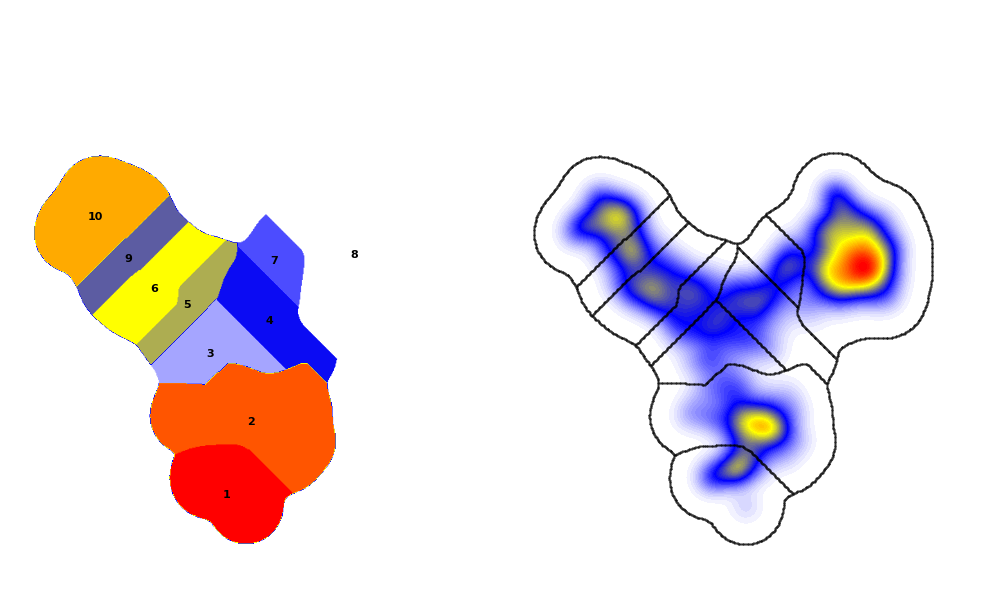

In [33]:
import matplotlib.pyplot as plt

startsigma = 4.2 if parameters.method == "TSNE" else 1.0
mmpy.findWatershedRegions(
    parameters,
    minimum_regions=10,
    startsigma=startsigma,
    pThreshold=[0.33, 0.67],
    saveplot=True,
    endident="*_pcaModes.mat",
)

from IPython.display import Image

Image(glob.glob("%s/%s/zWshed*.png" % (parameters.projectPath, parameters.method))[0])

# 8.&nbsp; Ethograms and videos

We can now create ethograms using the watershed region time series created in the last step. 

In [34]:
wshedfile = hdf5storage.loadmat(
    "%s/%s/zVals_wShed_groups.mat" % (parameters.projectPath, parameters.method)
)

wregs = wshedfile["watershedRegions"].flatten()
ethogram = np.zeros((wregs.max() + 1, len(wregs)))

for wreg in range(1, wregs.max() + 1):
    ethogram[wreg, np.where(wregs == wreg)[0]] = 1.0


ethogram = np.split(ethogram.T, np.cumsum(wshedfile["zValLens"][0].flatten())[:-1])

fig, axes = plt.subplots(2, 1, figsize=(20, 10))

for e, name, ax in zip(ethogram, wshedfile["zValNames"][0], axes.flatten()):
    print(e.shape)
    ax.imshow(e.T, aspect="auto", cmap=mmpy.gencmap())
    ax.set_title(name[0][0])
    ax.set_yticks([i for i in range(1, wregs.max() + 1, 4)])
    ax.set_yticklabels(["Region %i" % (j + 1) for j in range(1, wregs.max() + 1, 4)])

    xticklocs = [6000 * i for i in range(3)]
    ax.set_xticks(xticklocs)
    ax.set_xticklabels([j / (6000) for j in xticklocs])

ax.set_xlabel("Time (min)")

(20000, 11)
(20000, 11)


Text(0.5, 0, 'Time (min)')

## 8.1 Visualize behavioral map

Run the below code to see the behavioral map in action. 

This may take **2 minutes** to run. 

In [35]:
wshedfile = hdf5storage.loadmat(
    "%s/%s/zVals_wShed_groups.mat" % (parameters.projectPath, parameters.method)
)

try:
    tqdm._instances.clear()
except:
    pass

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
zValues = wshedfile["zValues"]
m = np.abs(zValues).max()


sigma = 1.0
_, xx, density = mmpy.findPointDensity(zValues, sigma, 511, [-m - 10, m + 10])
axes[0].imshow(
    density, cmap=mmpy.gencmap(), extent=(xx[0], xx[-1], xx[0], xx[-1]), origin="lower"
)
axes[0].axis("off")
axes[0].set_title("Method : %s" % parameters.method)
sc = axes[0].scatter([], [], marker="o", color="k", s=500)

h5ind = 0
tstart = 0
connections = [
    np.arange(6, 10),
    np.arange(10, 14),
    np.arange(14, 18),
    np.arange(18, 22),
    np.arange(22, 26),
    np.arange(26, 30),
    [2, 0, 1],
    [0, 3, 4, 5],
    [31, 3, 30],
]


def animate(t):
    t = int(t * clips[h5ind].fps) + tstart
    axes[1].clear()
    im = axes[1].imshow(
        clips[h5ind].get_frame(t / clips[h5ind].fps), cmap="Greys", origin="lower"
    )
    for conn in connections:
        axes[1].plot(h5s[h5ind][t, conn, 0], h5s[h5ind][t, conn, 1], "k-")
    axes[1].axis("off")
    sc.set_offsets(zValues[20000 * h5ind + t])
    return mplfig_to_npimage(fig)  # im, ax


anim = VideoClip(animate, duration=2)  # will throw memory error for more than 100.
plt.close()
anim.ipython_display(fps=15, loop=True, autoplay=True, maxduration=120)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


At this point, you know everything you need to know to create a behavioral map for a set of datasets. But this is where we can actually start doing some science! 

Open the project directory on the left pane. We should see some files in *Fly_Leap_mmpy/TSNE* or Fly_Leap_mmpy/UMAP folder. The 2-dimensional embeddings of all the files we've used for this project can be found in the **zVals_wShed_groups.mat** file which can be opened using hdf5storage in Python (as we did in the previous cell) or natively in MATLAB. This is where we can start doing some science!


In [ ]:
plt.figure()
plt.imshow(wshedfile["density"])

: 

In [ ]:
wshedfile["zValNames"]

: 

In [ ]:
wshedfile["zValLens"]

: 

In [ ]:
wshedfile["watershedRegions"].shape

: 

In [ ]:
wshedfile["zValues"].shape

: 

In [ ]:
list(wshedfile.keys())

: 

## 8.2 Create region videos



Now we'll try to create region videos - we'll pick contiguous time points that belong in one watershed region, and see what the animals is doing at those times by creating a movie.  

In [ ]:
def makeGroupsAndSegments(watershedRegions, zValLens, min_length=10, max_length=100):

    inds = np.zeros_like(watershedRegions)
    start = 0
    for l in zValLens:
        inds[start : start + l] = np.arange(l)
        start += l
    vinds = np.digitize(
        np.arange(watershedRegions.shape[0]),
        bins=np.concatenate([[0], np.cumsum(zValLens)]),
    )

    splitinds = np.where(np.diff(watershedRegions, axis=0) != 0)[0] + 1
    inds = [
        i
        for i in np.split(inds, splitinds)
        if len(i) > min_length and len(i) < max_length
    ]
    wregs = [
        i[0]
        for i in np.split(watershedRegions, splitinds)
        if len(i) > min_length and len(i) < max_length
    ]

    vinds = [
        i
        for i in np.split(vinds, splitinds)
        if len(i) > min_length and len(i) < max_length
    ]
    groups = [np.empty((0, 3), dtype=int)] * watershedRegions.max()

    for wreg, tind, vind in zip(wregs, inds, vinds):
        if np.all(vind == vind[0]):
            groups[wreg - 1] = np.concatenate(
                [
                    groups[wreg - 1],
                    np.array([vind[0], tind[0] + 1, tind[-1] + 1])[None, :],
                ]
            )
    groups = np.array([[g] for g in groups])
    return groups


def makeregionvideo(region, parameters, wshedfile):

    animfps = 50.0
    subs = 2
    submaxframes = 500

    groups = makeGroupsAndSegments(
        wshedfile["watershedRegions"][0], wshedfile["zValLens"][0]
    )
    nregs = len(groups)

    region = region - 1

    outputdir = "%s/%s/region_vidoes_%i/" % (
        parameters.projectPath,
        parameters.method,
        nregs,
    )
    if not os.path.exists(outputdir):
        os.mkdir(outputdir)
    groups = groups - 1
    print("[Region %i] Starting" % (region + 1))

    if os.path.isfile(outputdir + "regions_" + "%.3i" % (region + 1) + ".mp4"):
        print("[Region %i] Already present. " % (region + 1))
        return

    tqdm._instances.clear()

    if not groups[region][0].shape[0] or groups[region][0].shape[0] == 1:
        print("[Region %i] No frames in groups." % (region + 1))
        return

    nframes = np.atleast_1d(np.diff(groups[region][0][:, 1:], axis=1).squeeze())
    if np.sum(nframes < submaxframes) == 0:
        print(
            "[Region %i] All frames sequences more than length %i."
            % (region + 1, submaxframes)
        )
        return

    nplots = min(subs * subs, np.sum(nframes < submaxframes))
    longinds = np.where(nframes < submaxframes)[0]
    selectedclips = longinds[np.argsort(nframes[longinds])[::-1]][:nplots]

    vidindslist = groups[region][0][selectedclips, 0]
    framestoplot = np.array(
        [
            np.arange(groups[region][0][i, 1], groups[region][0][i, 2])
            for i in selectedclips
        ]
    )
    maxsize = max([i.shape[0] for i in framestoplot])

    print("[Region %i] Making region video..." % (region + 1))

    subx = max(2, int(np.ceil(np.sqrt(nplots))))
    fig, axes = plt.subplots(subx, subx, figsize=(12, 12))
    fig.subplots_adjust(0, 0, 1.0, 1.0, 0.0, 0.0)

    def make_frame(t):
        j_ = int(t * animfps)
        for i in range(subx * subx):

            ax = axes[i // subx, i % subx]
            ax.clear()
            ax.axis("off")
            if i >= nplots:
                continue
            j = j_ % len(framestoplot[i])
            clip = clips[vidindslist[i]]
            ax.imshow(
                clip.get_frame(framestoplot[i][j] / clip.fps),
                cmap="Greys_r",
                origin="lower",
            )
        return mplfig_to_npimage(fig)

    try:
        tqdm._instances.clear()
    except:
        pass

    t1 = time.time()
    animation = VideoClip(make_frame, duration=maxsize / animfps)

    animation.write_videofile(
        outputdir + "regions_" + "%.3i" % (region + 1) + ".mp4",
        fps=animfps,
        audio=False,
        threads=1,
    )

    print(
        "[Region %i] %i seconds, Saved at %s"
        % (
            region + 1,
            time.time() - t1,
            outputdir + "regions_" + "%.3i" % (region + 1) + ".mp4",
        )
    )

: 

In [ ]:
makeregionvideo(10, parameters, wshedfile)

: 

In [ ]:
# This creates region videos for all the region. This can take a while to run so be careful!
wmax = wshedfile["watershedRegions"].max()
print(wmax)
for i in range(1, wmax + 1):
    makeregionvideo(i, parameters, wshedfile)

: 

In [ ]:
# Set region below to see your video.
region = 10

print("Region %i" % region)
from IPython.display import HTML
from base64 import b64encode

outputdir = "%s/%s/region_vidoes_%i/" % (
    parameters.projectPath,
    parameters.method,
    wshedfile["watershedRegions"].max(),
)
mp4 = open(outputdir + "regions_" + "%.3i" % (region) + ".mp4", "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(
    """
<video width=400 controls loop autoplay>
      <source src="%s" type="video/mp4">
</video>
"""
    % data_url
)

: 



You can also zip your project folder by calling 
```!zip -r Fly_Leap_mmpy.zip Fly_Leap_mmpy``` 
and download the folder on your local computer to play around with it. 

In [ ]:
# !zip -r Fly_Leap_mmpy.zip Fly_Leap_mmpy

: 

# Transition Matrix

In [ ]:
wregs = wshedfile["watershedRegions"][0]
wregs = np.split(wregs, np.cumsum(wshedfile["zValLens"][0])[:-1])
transitions = [mmpy.demoutils.getTransitions(w[w > 0]) for w in wregs]

: 

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5))

statevals = np.arange(1, wshedfile["watershedRegions"].max() + 2)
for ax, d in zip(axes.flatten(), [1, 10, 100, 1000]):
    F = mmpy.demoutils.makeTransitionMatrix(np.concatenate(transitions), d)
    ax.imshow(
        F,
        cmap="PuRd",
        extent=(statevals[0], statevals[-1], statevals[0], statevals[-1]),
    )
    ax.set_xlabel("Initial State")
    ax.set_ylabel("Final State")

: 

In [ ]:
_ = mmpy.demoutils.plotLaggedEigenvalues(transitions)

: 

: 